# Setup inicial

In [2]:
import numpy as np
import pandas as pd
from collections import defaultdict

%matplotlib inline
from matplotlib import pyplot as plt

import seaborn as sns

from IPython.display import HTML, display
from sklearn import metrics
from sklearn.metrics import *
from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

import graphviz
from sklearn.tree import export_graphviz

from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer

import category_encoders as ce

from src.creditapp.data.raw_data_access import get_application_record

# Loading data

In [3]:
df_clients = get_application_record()

df_clients.drop(['id'], axis=1, inplace=True)

print('data loading was successfully...')

data loading was successfully...


<img src="https://av.sc.com/in/content/images/in-credit-card-banner-1600x490px.jpg" />

# Experiments

**Fecha de creación: 13/05/2020**

**Autores: Santiago Porchietto, Agustín Trulli**

El objetivo del presente cuaderno es la realización de multiples experimentos involucrando modelos de Machine Learning en función de determinar cual es el que mejor funciona para esta problemática en particular.

Como se menciona en el análisis anterior, se busca predecir si una persona incurrirá en incumplimiento de sus deudas contraidas mediante tarjeta de crédito. Para esto creamos la columna target (y).

Todas las features que quedaron en el dataset (menos el id) posterior al preprocessing serán utilizadas como entradas (X).

<u>Metricas a utilizar</u>:

* Precission: Para poder determinar que porcentaje de las veces que dijimos positivo acertamos la predicción. Por si sola es insuficiente (Encontramos 2 positivos que realmente lo son (100% de precission), en un dataset que posee 1000 positivos).

* Recall: Para complementar precission, nos va a decir el porcentaje de positivos que encontramos por sobre los reales.

* F1-Score: Como métrica que combina las anteriores.

Con nuestro ejemplo en particular, precission es la métrica que más deberíamos mirar, ya que, en función de las políticas que tome el banco contra los deudores, tendríamos que estar bastante seguros de que una persona lo es antes de etiquetarla de ello.

<u>Modelos a evaluar</u>:

* Decission Tree 

* Random Forest

* Logistic Regression

* K Nearest Neighbors (KNN)

* Gradient Boosted Trees

* Neural Networks (MLP)

## Feature Engineering

Debido a la contextura de nuestro dataset, que posee varias features de tipo boolean, no es posible realizar feature engineering a gran escala. Para emplear alguna de las técnicas vistas, realizamos el armado de rangos sobre features non-categorical altamente variables.

Por su parte, las features categóiricas no parecen evidenciar información oculta a extraer. 

### Months employed
Armado de los rangos de meses trabajados para "agrupado de valores similares" y reducción de variabilidad.

In [4]:
# parentesis no incluye el término
# corchete incluye el término

# Bajo la suposición de que estas personas nunca trabajaron o se encuentran este periodo de tiempo sin trabajar.
# Se debería consultar con el "cliente/banco", pero tiene sentido.
df_clients["months_employed"].fillna(0, inplace = True)

df_clients.loc[::, 'months_employed_range'] = pd.cut(df_clients.months_employed, 
                                                     list(range(0, 205, 6)), include_lowest='True')

df_clients['months_employed_range'] = df_clients['months_employed_range'].astype(str)
df_clients.loc[df_clients.months_employed_range == 'nan', 'months_employed_range'] = np.nan
df_clients.loc[df_clients.months_employed_range == '(-0.001, 6.0]', 'months_employed_range'] = '[0.0, 6.0]'
df_clients.loc[df_clients.months_employed >= 205, 'months_employed_range'] = '(204.0, 524.0]'

### Income total
Armado de los rangos de ingresos para "agrupado de valores similares" y reducción de variabilidad.

In [5]:
# parentesis no incluye el término
# corchete incluye el término

df_clients.loc[::, 'amt_income_range'] = pd.cut(df_clients.amt_income_total, 
                                               list(range(27000, 300001, 14325)), include_lowest='True')

df_clients['amt_income_range'] = df_clients['amt_income_range'].astype(str)
df_clients.loc[df_clients.amt_income_range == '(26999.999, 41325.0]', 'amt_income_range'] = '[27000.0, 41325.0]'
df_clients.loc[df_clients.amt_income_total > 300000, 'amt_income_range'] = '(300000.0, 1575000.0]'

## Utils

In [6]:
def evaluate_model(model, set_names=('train', 'test', 'validation'), title='', show_cm=True):
    if title:
        display(title)
    final_metrics = defaultdict(list)
    if show_cm:
        fig, axis = plt.subplots(1, len(set_names), sharey=True, figsize=(15, 3))
        
    for i, set_name in enumerate(set_names):
        assert set_name in ['train', 'test', 'validation']
        set_data = globals()[set_name] 

        y = set_data.target
        y_pred = model.predict(set_data)
        final_metrics['Accuracy'].append(metrics.accuracy_score(y, y_pred))
        final_metrics['Precision'].append(metrics.precision_score(y, y_pred))
        final_metrics['Recall'].append(metrics.recall_score(y, y_pred))
        final_metrics['F1'].append(metrics.f1_score(y, y_pred))
        
        if show_cm:
            ax = axis[i]
            sns.heatmap(metrics.confusion_matrix(y, y_pred), ax=ax, cmap='Greens', annot=True, fmt='.0f', cbar=False)

            ax.set_title(set_name)
            ax.xaxis.set_ticklabels(['deudor', 'no deudor'])
            ax.yaxis.set_ticklabels(['deudor', 'no deudor'])
            ax.set_xlabel('Predicted class')
            ax.set_ylabel('True class')

        
    display(pd.DataFrame(final_metrics, index=set_names))
    if show_cm:
        plt.tight_layout()
        plt.show()

In [7]:
def graph_tree(tree, col_names):
    graph_data = export_graphviz(
        tree, 
        out_file=None, 
        feature_names=col_names,  
        class_names=['deudor', 'no deudor'],  
        filled=True, 
        rounded=True,  
        special_characters=True,
        max_depth=3,
    )
    graph = graphviz.Source(graph_data)  
    return graph

In [8]:
def get_best_scores(grid_search):
    print('----------------------------------------------------------------------------------------------------------------------------')
    print('Mejor score (F1): ', round(grid_search.best_score_, 5))
    print('Mejores parámetros: \n', grid_search.best_params_)
    print('----------------------------------------------------------------------------------------------------------------------------')

In [20]:
def get_model_results(i, experiments):
    for grid_search, pipe in experiments:
        i += 1
        evaluate_model(pipe, title=f'Experiment {i}')
        get_best_scores(grid_search)

## Generating test, train & validation sets 
Decidimos utilizar el 70% del dataset para train (6618 registros) y el 30% restante para test y validation (1418 para cada uno).

In [9]:
# Test, train & validation sets
train, not_train = train_test_split(df_clients, test_size=0.3, random_state=1)
validation, test = train_test_split(not_train, test_size=0.5, random_state=1)

print('data generating was successfully...')

data generating was successfully...


## Mapper

In [10]:
mapper = DataFrameMapper([
    (['code_gender'], [ce.OneHotEncoder()]),
    (['flag_own_car'], [ce.OneHotEncoder()]),
    (['flag_own_realty'], [ce.OneHotEncoder()]),
    (['cnt_children'], [StandardScaler()]),
    (['name_income_type'], [ce.WOEEncoder()]),
    (['name_education_type'], [ce.WOEEncoder()]),
    (['name_family_status'], [ce.WOEEncoder()]),
    (['name_housing_type'], [ce.WOEEncoder()]),
    (['months_employed_range'], [ce.WOEEncoder()]),
    (['amt_income_range'], [ce.WOEEncoder()]),
    (['occupation_type'], [ce.WOEEncoder()]),
    (['cnt_fam_members'], [StandardScaler()]),
    (['age'], [StandardScaler()]),
    (['flag_mobil'], None),
    (['flag_work_phone'], None),
    (['flag_email'], None),
    (['flag_phone'], None)
])

<u> Los criterios para el armado del mapper fueron los siguientes</u>:

* Se realizó el scaling de los meses trabajados debido a la alta mutabilidad de dicha feature, ajustándola a una distribución con media 0 y desvío estándar 1.

* Para features binarias y categóricas de poca "variabilidad" tales como el género o si la persona posee auto utilizamos OneHotEncoder.

* Para features categóticas con un rango de valores mayor tales como el tipo de ocupación o el tipo de vivienda, utilizamos Weight of Evidence Encoding (WOEE). Este método fue desarrollado principalmente para construir un modelo predictivo para evaluar el riesgo de incumplimiento de préstamos en la industria crediticia y financiera.

Se basa en una medida de cuánto la evidencia apoya o socava una hipótesis. Se calcula en función de:

<img src=https://4.bp.blogspot.com/-X1m0w40w0xg/V9V_7LS1AQI/AAAAAAAAFWc/f4bgPvE1In8Q13kGGBghp98MeWma8KgqACLcB/s1600/woe.png>

<u>Donde</u>:

* Distribution of Goods: Registros que cumplen con el target (pagaron, "buenos clientes").
* Distribution of Bads: Registros que no cumplen con el target (no pagaron, "malos clientes").

<u> Interpretación</u>:

**WOE va a ser 0 si P(GOOD)/P(BAD) = 1 (iguales).**
**WOE va a ser menor a 0 si P(GOOD) < P(BAD) (La razon de probabilidad entre ambas será menor a 1). Menos chances de cumplir.**
**WOE va a ser mayor a 0 si P(GOOD) > P(BAD) (La razon de probabilidad entre ambas será mayor a 1). Mas chances de cumplir.**

<u>Además</u>:

<img src="https://miro.medium.com/max/600/1*9Gi0fGyTpxfwM2TpV4GZQQ.png" width="300" height="50">



<img src=https://miro.medium.com/max/578/1*5S_5aAHWe0_knDGZUK3W8w.png width="300" height="200">

*see more: http://contrib.scikit-learn.org/category_encoders/woe.html*

## Models

### Decission Tree

In [72]:
def get_tree_config(max_depths=[None], min_samples_split=[2], min_samples_leaf=[1]):
    params = {
            'max_depth': max_depths,
            'criterion': ['entropy', 'gini'],
            'class_weight': [{0: 1, 1: 8}, 'balanced'],
            'min_samples_split': min_samples_split,
            'min_samples_leaf': min_samples_leaf
        }
    
    model = DecisionTreeClassifier(random_state=1)
    
    return model, params

In [73]:
def make_tree_predictions(model, parameters):
    grid_search_tree = GridSearchCV(model, parameters, 
                                scoring='f1', verbose=1)

    pipe_tree = Pipeline([
        ('mapper', mapper),
        ('imputer', IterativeImputer(random_state=1)),
        ('classifier', grid_search_tree),
    ])

    pipe_tree.fit(train, train.target)
    
    return pipe_tree, grid_search_tree

In [74]:
model_1, parameters_1 = get_tree_config(max_depths=[5,6,7], 
                                        min_samples_split=[80,100], 
                                        min_samples_leaf=[10,15,20,30])

model_2, parameters_2 = get_tree_config(max_depths=[9,10,11], 
                                        min_samples_split=[80,100], 
                                        min_samples_leaf=[10,15,20,30])

model_3, parameters_3 = get_tree_config(max_depths=[5,6,7,9,10,11])

model_4, parameters_4 = get_tree_config(max_depths=[5,6,7], 
                                        min_samples_split=[80,100,130,170], 
                                        min_samples_leaf=[15,20,30,40,50])

model_5, parameters_5 = get_tree_config(max_depths=[5,6,7], 
                                        min_samples_split=[60,70,80,100,130], 
                                        min_samples_leaf=[30,40,50,65,90])

pipe_tree_1, grid_search_tree_1 = make_tree_predictions(model_1, parameters_1)
pipe_tree_2, grid_search_tree_2 = make_tree_predictions(model_2, parameters_2)
pipe_tree_3, grid_search_tree_3 = make_tree_predictions(model_3, parameters_3)
pipe_tree_4, grid_search_tree_4 = make_tree_predictions(model_4, parameters_4)
pipe_tree_5, grid_search_tree_5 = make_tree_predictions(model_5, parameters_5)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 480 out of 480 | elapsed:    9.0s finished


Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 480 out of 480 | elapsed:   13.3s finished


Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    2.7s finished


Fitting 5 folds for each of 240 candidates, totalling 1200 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1200 out of 1200 | elapsed:   22.6s finished


Fitting 5 folds for each of 300 candidates, totalling 1500 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1500 out of 1500 | elapsed:   27.5s finished


'Experiment 1'

,Accuracy,Precision,Recall,F1
train,0.439861,0.110207,0.820183,0.194306
test,0.436927,0.106236,0.786325,0.187182
validation,0.392102,0.072645,0.587156,0.129293


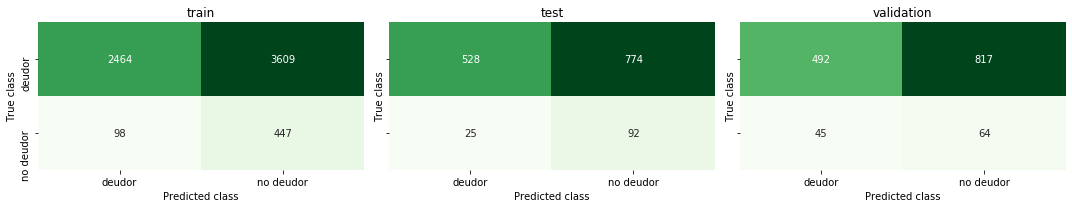

----------------------------------------------------------------------------------------------------------------------------
Mejor score (F1):  0.18127
Mejores parámetros: 
 {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 6, 'min_samples_leaf': 20, 'min_samples_split': 100}
----------------------------------------------------------------------------------------------------------------------------


'Experiment 2'

,Accuracy,Precision,Recall,F1
train,0.528407,0.127746,0.811009,0.220724
test,0.516561,0.113976,0.717949,0.196721
validation,0.458392,0.078105,0.559633,0.137079


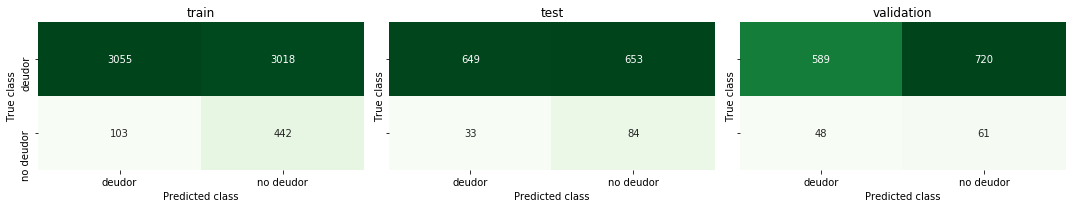

----------------------------------------------------------------------------------------------------------------------------
Mejor score (F1):  0.17983
Mejores parámetros: 
 {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 30, 'min_samples_split': 100}
----------------------------------------------------------------------------------------------------------------------------


'Experiment 3'

,Accuracy,Precision,Recall,F1
train,0.443941,0.112101,0.831193,0.197558
test,0.439746,0.106729,0.786325,0.187947
validation,0.394922,0.072976,0.587156,0.129817


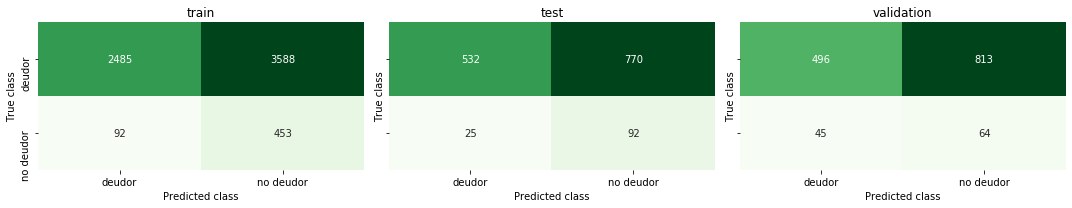

----------------------------------------------------------------------------------------------------------------------------
Mejor score (F1):  0.17969
Mejores parámetros: 
 {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 6, 'min_samples_leaf': 1, 'min_samples_split': 2}
----------------------------------------------------------------------------------------------------------------------------


'Experiment 4'

,Accuracy,Precision,Recall,F1
train,0.480508,0.117024,0.811009,0.204535
test,0.469345,0.105459,0.726496,0.184182
validation,0.435120,0.082126,0.623853,0.145144


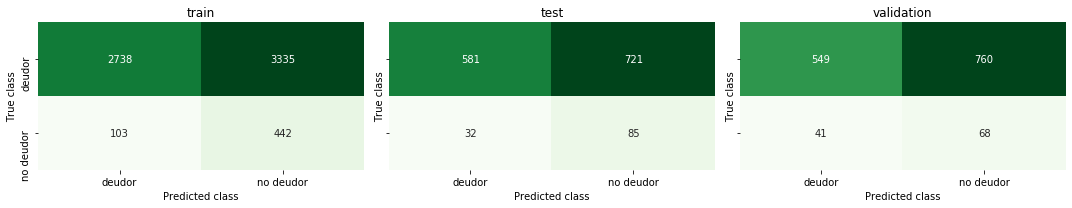

----------------------------------------------------------------------------------------------------------------------------
Mejor score (F1):  0.18392
Mejores parámetros: 
 {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 6, 'min_samples_leaf': 50, 'min_samples_split': 80}
----------------------------------------------------------------------------------------------------------------------------


'Experiment 5'

,Accuracy,Precision,Recall,F1
train,0.480508,0.117024,0.811009,0.204535
test,0.469345,0.105459,0.726496,0.184182
validation,0.435120,0.082126,0.623853,0.145144


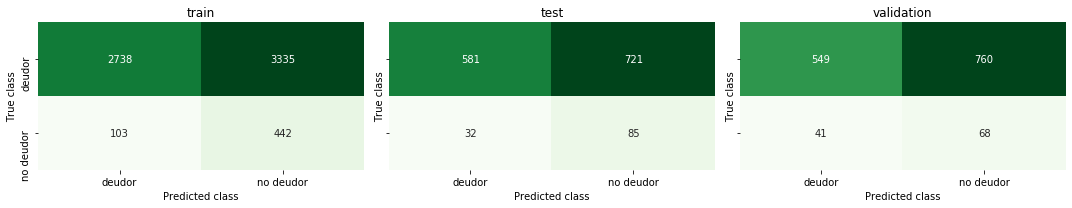

----------------------------------------------------------------------------------------------------------------------------
Mejor score (F1):  0.18392
Mejores parámetros: 
 {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 6, 'min_samples_leaf': 50, 'min_samples_split': 60}
----------------------------------------------------------------------------------------------------------------------------


In [75]:
i = 0
experiments = [(grid_search_tree_1, pipe_tree_1), 
               (grid_search_tree_2, pipe_tree_2), 
               (grid_search_tree_3, pipe_tree_3), 
               (grid_search_tree_4, pipe_tree_4), 
               (grid_search_tree_5, pipe_tree_5)]

get_model_results(i, experiments)

<u>Conclusiones generales</u>:

En función de los resultados podemos determinar que la config de modelo que mas se ajusta a nuestro problema es la referente al *experimento 2*, ya que, como mencionamos en un principio, precission va a tener un mayor peso debido a las "represarias" que se podrian tomar contra un cliente clasificado erroneamente como deudor.

No obstante, es importante tener en cuenta que el parámetro "min_samples_leaf" en este último es de 30, por lo que podriamos etiquetar como "deudores" a una hoja que contenga 30 samples. Deberíamos verificar con el cliente, en función de la lógica de negocio, que tan correcta es esta postura.

Por otra parte, los scores alcanzados por los demás experimentos tampoco difieren mucho de los resultados alcanzados por la config elegida (aprox. 1%). Por lo tanto, llegamos a la conclusión de que, el tunning de hiperparámetros no nos va a impactar casi nada en los resultados finales (como sí lo haría conseguir más datos, realizar más feature engeneering, etc).

<u>Arbol del experimento 2</u>:

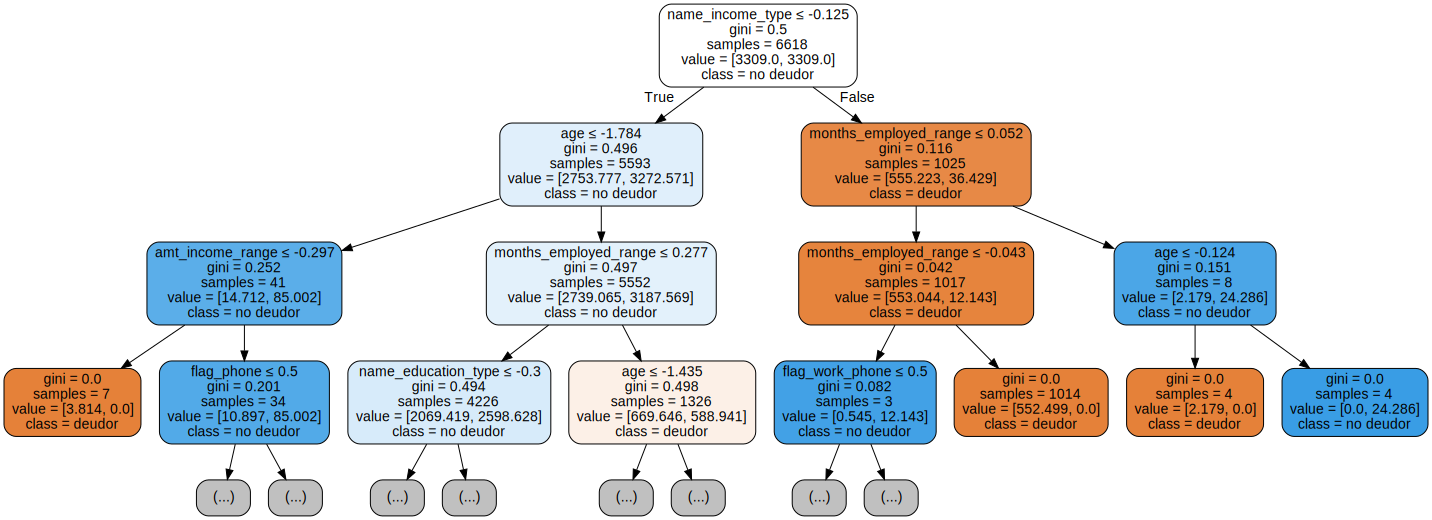

In [29]:
graph_tree(grid_search_tree_2.best_estimator_, mapper.transformed_names_)

<u>Resultados de los experimentos</u>:
* Solo el 11% de las veces que el arbol dijo 1 (deudor) acertó a la predicción.
* No obstante, es capaz de encontrar el 72%-78% de los deudores (en función de la config). Esto nos lleva a penar que el modelo esta clasificando muchas veces como deudor a clientes que, en realidad, no lo son.
* Debido a la amplia diferencia entre estas métricas, la mejor configuración para este modelo nos arroja un F1 de apenas  ≈0.20.

### Random Forests

In [11]:
def get_forest_config(estimators=[100], max_depths=[None], min_samples_split=[2], min_samples_leaf=[1]):
    params = {
            'n_estimators': estimators,
            'max_depth': max_depths,
            'criterion': ['entropy', 'gini'],
            'class_weight': [{0: 1, 1: 8}, 'balanced'],
            'n_jobs': [-1],
            'min_samples_split': min_samples_split,
            'min_samples_leaf': min_samples_leaf
        }
    
    model = RandomForestClassifier(random_state=1)
    
    return model, params

In [12]:
def make_forest_predictions(model, parameters):
    grid_search_forest = GridSearchCV(model, parameters, 
                                      scoring='f1', verbose=1)

    pipe_forest = Pipeline([
        ('mapper', mapper),
        ('imputer', IterativeImputer(random_state=1)),
        ('classifier', grid_search_forest),
    ])

    pipe_forest.fit(train, train.target)
    
    return pipe_forest, grid_search_forest

In [13]:
model_1, parameters_1 = get_forest_config(max_depths=[5,6,7],
                                          estimators=[100,200,300],
                                          min_samples_split=[80,100], 
                                          min_samples_leaf=[10,15,20,30])

model_2, parameters_2 = get_forest_config(max_depths=[9,10,11],
                                          estimators=[100,200,300],
                                          min_samples_split=[80,100], 
                                          min_samples_leaf=[10,15,20,30])

pipe_forest_1, grid_search_forest_1 = make_forest_predictions(model_1, parameters_1)
pipe_forest_2, grid_search_forest_2 = make_forest_predictions(model_2, parameters_2)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1440 out of 1440 | elapsed: 15.4min finished


Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1440 out of 1440 | elapsed: 16.6min finished


'Experiment 1'

,Accuracy,Precision,Recall,F1
train,0.457389,0.120956,0.891743,0.213018
test,0.434813,0.109464,0.820513,0.193159
validation,0.399859,0.079365,0.642202,0.141271


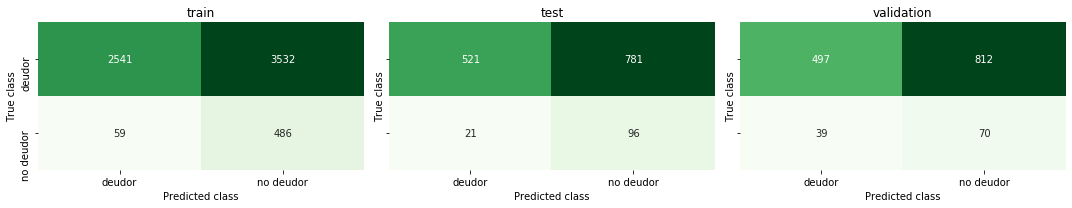

----------------------------------------------------------------------------------------------------------------------------
Mejor score (F1):  0.18325
Mejores parámetros: 
 {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 10, 'min_samples_split': 100, 'n_estimators': 300, 'n_jobs': -1}
----------------------------------------------------------------------------------------------------------------------------


'Experiment 2'

,Accuracy,Precision,Recall,F1
train,0.723330,0.210099,0.855046,0.337315
test,0.648344,0.110204,0.461538,0.177924
validation,0.638928,0.087935,0.394495,0.143813


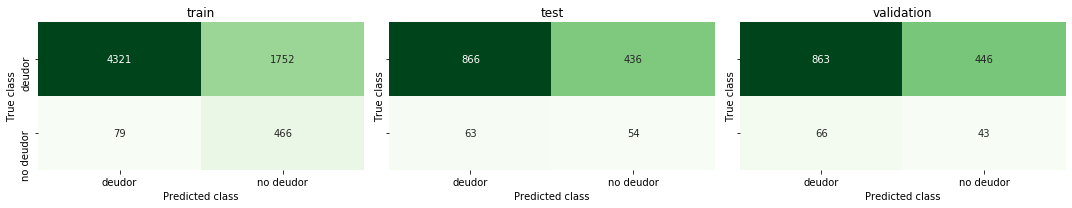

----------------------------------------------------------------------------------------------------------------------------
Mejor score (F1):  0.17393
Mejores parámetros: 
 {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 11, 'min_samples_leaf': 30, 'min_samples_split': 100, 'n_estimators': 300, 'n_jobs': -1}
----------------------------------------------------------------------------------------------------------------------------


In [22]:
i=0
experiments = [(grid_search_forest_1, pipe_forest_1), 
               (grid_search_forest_2, pipe_forest_2)]

get_model_results(i, experiments)

<u>Conclusiones generales</u>:

Las 2 configs ejecutadas difieren en la profundidad utilizada por los trees de los que se compone el modelo. En la primera de estas, podemos ver como se obtiene un mayor recall pero un precission levemente inferior. Por su parte, la segunda config pierde en recall score, pero gana 1 punto en precission (lo cual tiene sentido debido a que a mayor profundidad, mas cortes se realizaran, y por lo tanto, mas se particionará la data).

En función de lo dicho, vamos a probar el tunning de *min_samples_leaf* para la configuración que mejor performance tuvo (aunque la diferencia es poca), para ver como se comporta al tener que determinar nodos hoja con una mayor cantidad de samples. 

In [23]:
model_3, parameters_3 = get_forest_config(max_depths=[9,10,11],
                                          estimators=[100,200,300],
                                          min_samples_split=[80], 
                                          min_samples_leaf=[30,40,50,60])

pipe_forest_3, grid_search_forest_3 = make_forest_predictions(model_3, parameters_3)

Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 720 out of 720 | elapsed:  9.8min finished


'Experiment 3'

,Accuracy,Precision,Recall,F1
train,0.635539,0.164571,0.840367,0.275240
test,0.574348,0.107890,0.572650,0.181572
validation,0.551481,0.079745,0.458716,0.135870


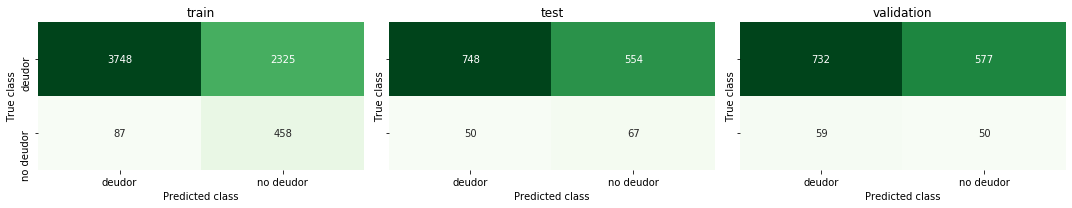

----------------------------------------------------------------------------------------------------------------------------
Mejor score (F1):  0.17623
Mejores parámetros: 
 {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 9, 'min_samples_leaf': 50, 'min_samples_split': 80, 'n_estimators': 300, 'n_jobs': -1}
----------------------------------------------------------------------------------------------------------------------------


In [24]:
i=2
experiments = [(grid_search_forest_3, pipe_forest_3)]

get_model_results(i, experiments)

Se puede obervar claramente como subimos en recall pero bajamos en precission (aunque sea poco).

En conclusión, en base a los resultados obtenidos, debemos determinar con el cliente cual es el trade-off entre un buen precission y un buen recall, ya que, en esta ultima config pudimos observar que, al aumentar el numero de *min_samples_leaf* el modelo elige quedarse con una profundidad menor, debido que la cantidad de samples para que un nodo sea considerado es mayor y realiza menos cortes.

Más allá de lo mencionado, creemos que el experimento 3 es el mas indicado, debido a que, a costa de bajar muy poco precission, gana mucho en recall comparado con el experimento 2.

<u>Resultados</u>:
* Solo el ≈11% de las veces que el arbol dijo 1 (deudor) acertó a la predicción.
* En esta ocasión, es capaz de encontrar el ≈57% de los deudores. Esto nos lleva a penar, que a diferencia del decission tree, el forest esta diciendo "esta persona será deudor" en una proporción menor.
* Debido a la diferencia entre estas métricas, la mejor configuración para random forest nos arroja un F1 de apenas  ≈0.18.

### Logistic Regression

In [87]:
def get_logistic_regression_config(max_iters=[100]):
    params = {
            'penalty': ['l1', 'l2', 'elasticnet'],
            'C': [0.1, 1, 0.5],
            'max_iter': max_iters,
            'class_weight': [{0: 1, 1: 8}, 'balanced'], 
            'solver': ['lbfgs', 'liblinear']
        }
    
    model = LogisticRegression(random_state=1)
    
    return model, params

In [88]:
def make_LR_predictions(model, parameters):
    grid_search_lr = GridSearchCV(model, parameters, 
                                  scoring='f1', verbose=1)

    pipe_lr = Pipeline([
        ('mapper', mapper),
        ('imputer', IterativeImputer(random_state=1)),
        ('classifier', grid_search_lr),
    ])

    pipe_lr.fit(train, train.target)
    
    return pipe_lr, grid_search_lr

In [89]:
model_1, parameters_1 = get_logistic_regression_config(max_iters=[50,70,90,100])
model_2, parameters_2 = get_logistic_regression_config(max_iters=[10,20,30,40])
model_3, parameters_3 = get_logistic_regression_config(max_iters=[200,300,400])

pipe_lr_1, grid_search_lr_1 = make_LR_predictions(model_1, parameters_1)
pipe_lr_2, grid_search_lr_2 = make_LR_predictions(model_2, parameters_2)
pipe_lr_3, grid_search_lr_3 = make_LR_predictions(model_3, parameters_3)

Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\agus_\Miniconda3\envs\venv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
C:\Users\agus_\Miniconda3\envs\venv\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\agus_\Miniconda3\envs\venv\lib\site-pa

C:\Users\agus_\Miniconda3\envs\venv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got elasticnet penalty.

  FitFailedWarning)
C:\Users\agus_\Miniconda3\envs\venv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.

  FitFailedWarning)
C:\Users\agus_\Miniconda3\envs\venv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
C

C:\Users\agus_\Miniconda3\envs\venv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got elasticnet penalty.

  FitFailedWarning)
C:\Users\agus_\Miniconda3\envs\venv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.

  FitFailedWarning)
C:\Users\agus_\Miniconda3\envs\venv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
C

C:\Users\agus_\Miniconda3\envs\venv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got elasticnet penalty.

  FitFailedWarning)
C:\Users\agus_\Miniconda3\envs\venv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.

  FitFailedWarning)
C:\Users\agus_\Miniconda3\envs\venv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
C

C:\Users\agus_\Miniconda3\envs\venv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got elasticnet penalty.

  FitFailedWarning)
C:\Users\agus_\Miniconda3\envs\venv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.

  FitFailedWarning)
C:\Users\agus_\Miniconda3\envs\venv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
C

Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\agus_\Miniconda3\envs\venv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
C:\Users\agus_\Miniconda3\envs\venv\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\agus_\Miniconda3\envs\venv\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\agus_\Miniconda3\envs\venv\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iter

C:\Users\agus_\Miniconda3\envs\venv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got elasticnet penalty.

  FitFailedWarning)
C:\Users\agus_\Miniconda3\envs\venv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.

  FitFailedWarning)
C:\Users\agus_\Miniconda3\envs\venv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
C

C:\Users\agus_\Miniconda3\envs\venv\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\agus_\Miniconda3\envs\venv\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_m

C:\Users\agus_\Miniconda3\envs\venv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got elasticnet penalty.

  FitFailedWarning)
C:\Users\agus_\Miniconda3\envs\venv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.

  FitFailedWarning)
C:\Users\agus_\Miniconda3\envs\venv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
C

C:\Users\agus_\Miniconda3\envs\venv\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\agus_\Miniconda3\envs\venv\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\agus_\Miniconda3\envs\venv\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\agus_\Miniconda3\envs\venv\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer

C:\Users\agus_\Miniconda3\envs\venv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got elasticnet penalty.

  FitFailedWarning)
C:\Users\agus_\Miniconda3\envs\venv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.

  FitFailedWarning)
C:\Users\agus_\Miniconda3\envs\venv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
C

C:\Users\agus_\Miniconda3\envs\venv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got elasticnet penalty.

  FitFailedWarning)
C:\Users\agus_\Miniconda3\envs\venv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.

  FitFailedWarning)
C:\Users\agus_\Miniconda3\envs\venv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
C

C:\Users\agus_\Miniconda3\envs\venv\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\agus_\Miniconda3\envs\venv\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_m

C:\Users\agus_\Miniconda3\envs\venv\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\agus_\Miniconda3\envs\venv\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_m

C:\Users\agus_\Miniconda3\envs\venv\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\agus_\Miniconda3\envs\venv\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_m

C:\Users\agus_\Miniconda3\envs\venv\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\agus_\Miniconda3\envs\venv\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\agus_\Miniconda3\envs\venv\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) o

Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\agus_\Miniconda3\envs\venv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
C:\Users\agus_\Miniconda3\envs\venv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got elasticnet penalty.

  FitFailedWarning)
C:\Users\agus_\Miniconda3\envs\venv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Only 'saga'

C:\Users\agus_\Miniconda3\envs\venv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got elasticnet penalty.

  FitFailedWarning)
C:\Users\agus_\Miniconda3\envs\venv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.

  FitFailedWarning)
C:\Users\agus_\Miniconda3\envs\venv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
C

C:\Users\agus_\Miniconda3\envs\venv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got elasticnet penalty.

  FitFailedWarning)
C:\Users\agus_\Miniconda3\envs\venv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.

  FitFailedWarning)
[Parallel(n_jobs=1)]: Done 540 out of 540 | elapsed:   16.8s finished


**Results**

'Experiment 1'

,Accuracy,Precision,Recall,F1
train,0.550620,0.105810,0.598165,0.179812
test,0.539112,0.101040,0.581197,0.172152
validation,0.549365,0.094801,0.568807,0.162516


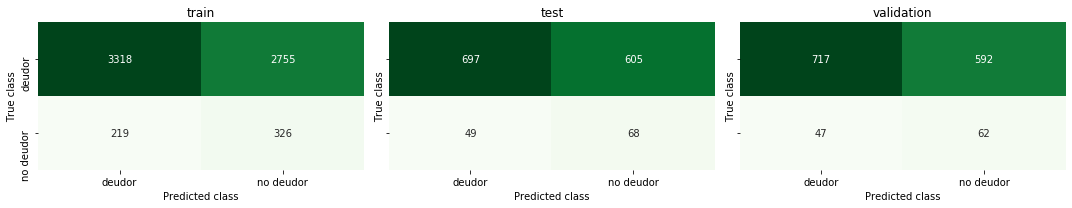

----------------------------------------------------------------------------------------------------------------------------
Mejor score (F1):  0.16956
Mejores parámetros: 
 {'C': 0.5, 'class_weight': 'balanced', 'max_iter': 50, 'penalty': 'l2', 'solver': 'liblinear'}
----------------------------------------------------------------------------------------------------------------------------


'Experiment 2'

,Accuracy,Precision,Recall,F1
train,0.552886,0.105813,0.594495,0.179651
test,0.539817,0.101190,0.581197,0.172370
validation,0.552186,0.094136,0.559633,0.161162


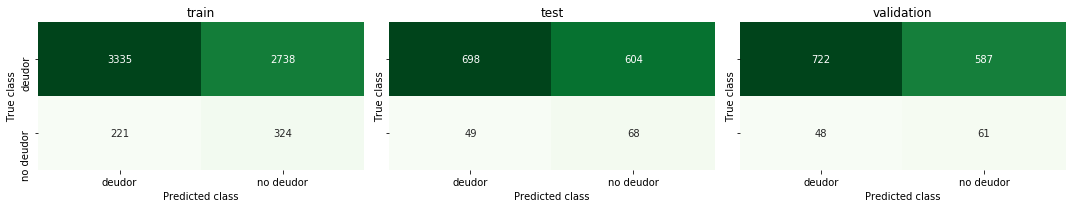

----------------------------------------------------------------------------------------------------------------------------
Mejor score (F1):  0.1706
Mejores parámetros: 
 {'C': 1, 'class_weight': 'balanced', 'max_iter': 20, 'penalty': 'l2', 'solver': 'lbfgs'}
----------------------------------------------------------------------------------------------------------------------------


'Experiment 3'

,Accuracy,Precision,Recall,F1
train,0.550620,0.105810,0.598165,0.179812
test,0.539112,0.101040,0.581197,0.172152
validation,0.549365,0.094801,0.568807,0.162516


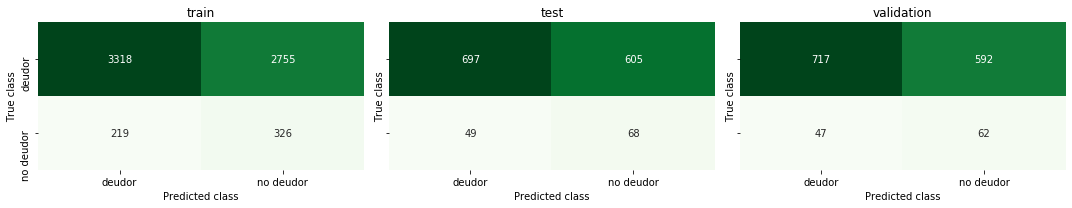

----------------------------------------------------------------------------------------------------------------------------
Mejor score (F1):  0.16956
Mejores parámetros: 
 {'C': 0.5, 'class_weight': 'balanced', 'max_iter': 200, 'penalty': 'l2', 'solver': 'liblinear'}
----------------------------------------------------------------------------------------------------------------------------


In [90]:
i = 0
experiments = [(grid_search_lr_1, pipe_lr_1), 
               (grid_search_lr_2, pipe_lr_2), 
               (grid_search_lr_3, pipe_lr_3)]

get_model_results(i, experiments)

<u>Conclusiones generales</u>:

Luego de variar el numero de iteraciónes necesarios para que el *solver* del modelo converja en una solución (100 por default), y, tambíen habiendo incluido el *solver* "liblinear" (recomendado para dataset de pequeñas dimensiones), llegamos a la conclusión que el modelo logistic regression no es apropiado para nuestro problema, ya que apenas varían los resultados permutando los parámetros.

<u>Mejor modelo: cualquiera a ellos</u>:
* Solo el 10% de las veces que el modelo dijo 1 (deudor) acertó a la predicción.
* No obstante, es capaz de encontrar el 58% de los deudores. Esto significa que está pasando algo similar a los modelos anteriores, el modelo está clasificando muchas veces como deudor a clientes que, en realidad, no lo son, pero en menor medida.
* Debido a la diferencia existente entre estas métricas, la mejor configuración para la logistic regression nos arroja un F1 de apenas ≈0.17.

### K Nearest Neighbors (KNN)

**With grid search**

In [93]:
def get_knn_config(neighbors=[5]):
    params = {
            'n_neighbors': neighbors,
            'weights': ['uniform', 'distance'],
            'algorithm': ['auto'],
            'p': [1, 2],
            'n_jobs': [-1]
        }
    
    model = KNeighborsClassifier()
    
    return model, params

In [94]:
def make_KNN_predictions(model, parameters):
    grid_search_knn = GridSearchCV(model, parameters, 
                                   scoring='f1', verbose=1)

    pipe_knn = Pipeline([
        ('mapper', mapper),
        ('imputer', IterativeImputer(random_state=1)),
        ('classifier', grid_search_knn),
    ])

    pipe_knn.fit(train, train.target)
    
    return pipe_knn, grid_search_knn

In [95]:
model_1, parameters_1 = get_knn_config(neighbors=[3,4,5])
model_2, parameters_2 = get_knn_config(neighbors=[5,6,7])
model_3, parameters_3 = get_knn_config(neighbors=[10,15,18])

pipe_knn_1, grid_search_knn_1 = make_KNN_predictions(model_1, parameters_1)
pipe_knn_2, grid_search_knn_2 = make_KNN_predictions(model_2, parameters_2)
pipe_knn_3, grid_search_knn_3 = make_KNN_predictions(model_3, parameters_3)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:   16.8s finished


Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:   11.7s finished


Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:   14.6s finished


**Results**

'Experiment 1'

,Accuracy,Precision,Recall,F1
train,1.000000,1.000000,1.000000,1.000000
test,0.899225,0.157895,0.051282,0.077419
validation,0.898449,0.093023,0.036697,0.052632


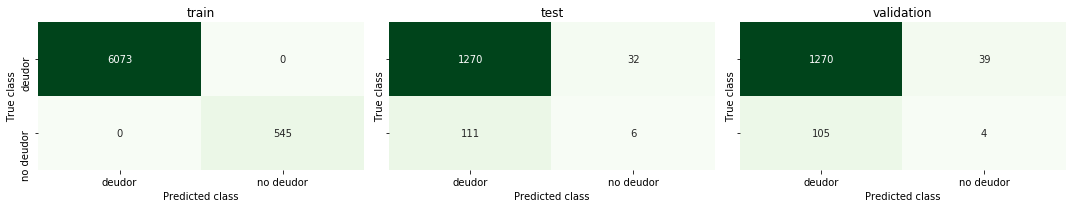

----------------------------------------------------------------------------------------------------------------------------
Mejor score (F1):  0.0357
Mejores parámetros: 
 {'algorithm': 'auto', 'n_jobs': -1, 'n_neighbors': 3, 'p': 1, 'weights': 'distance'}
----------------------------------------------------------------------------------------------------------------------------


'Experiment 2'

,Accuracy,Precision,Recall,F1
train,1.000000,1.000000,1.000000,1.000000
test,0.909091,0.071429,0.008547,0.015267
validation,0.918900,0.000000,0.000000,0.000000


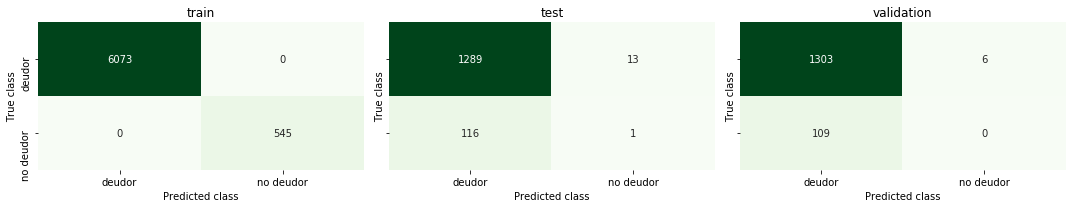

----------------------------------------------------------------------------------------------------------------------------
Mejor score (F1):  0.00985
Mejores parámetros: 
 {'algorithm': 'auto', 'n_jobs': -1, 'n_neighbors': 5, 'p': 2, 'weights': 'distance'}
----------------------------------------------------------------------------------------------------------------------------


'Experiment 3'

C:\Users\agus_\Miniconda3\envs\venv\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\agus_\Miniconda3\envs\venv\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\agus_\Miniconda3\envs\venv\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Accuracy,Precision,Recall,F1
train,0.917649,0.0,0.0,0.0
test,0.917548,0.0,0.0,0.0
validation,0.923131,0.0,0.0,0.0


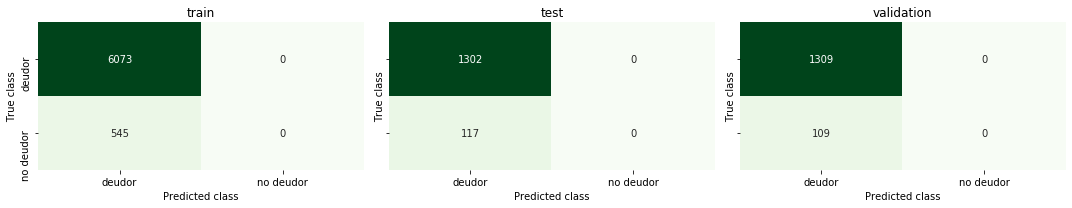

----------------------------------------------------------------------------------------------------------------------------
Mejor score (F1):  0.0
Mejores parámetros: 
 {'algorithm': 'auto', 'n_jobs': -1, 'n_neighbors': 10, 'p': 1, 'weights': 'uniform'}
----------------------------------------------------------------------------------------------------------------------------


In [96]:
i = 0
experiments = [(grid_search_knn_1, pipe_knn_1), 
               (grid_search_knn_2, pipe_knn_2), 
               (grid_search_knn_3, pipe_knn_3)]

get_model_results(i, experiments)

<u>Conclusiones generales</u>:

En los 2 primeros experimentos podemos observar que KNN se queda con el menor número de vecinos posibles (3 y 5 respectivamente), y se produce overfiting. En cambio, en el tercer experimento ocurre justamente lo contrario: si bien toma el menor numero de vecinos disponibles (10), no es capaz de atinar a ninguna de las predicciones positivas. Como se puede observar en accuracy, un 9% de las veces se arriesgo a decir "este será deudor", pero nunca acertó (underfiting).

En función de lo dicho, comprobaremos manualmente con que número de vecinos se produce esta diferenciación:

In [97]:
model_4, parameters_4 = get_knn_config(neighbors=[7])
model_5, parameters_5 = get_knn_config(neighbors=[8])

pipe_knn_4, grid_search_knn_4 = make_KNN_predictions(model_4, parameters_4)
pipe_knn_5, grid_search_knn_5 = make_KNN_predictions(model_5, parameters_5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    8.2s finished


Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    4.8s finished


'Experiment 4'

,Accuracy,Precision,Recall,F1
train,1.000000,1.0,1.0,1.0
test,0.912615,0.0,0.0,0.0
validation,0.921721,0.0,0.0,0.0


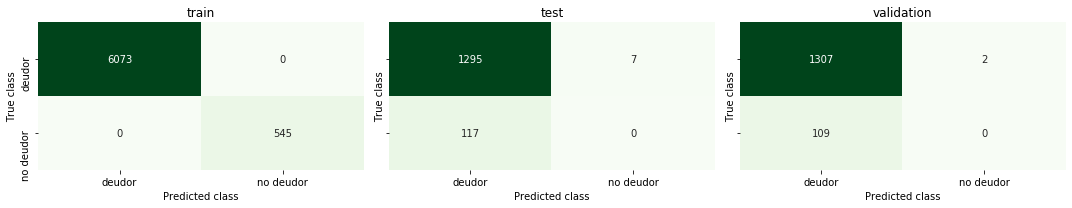

----------------------------------------------------------------------------------------------------------------------------
Mejor score (F1):  0.00339
Mejores parámetros: 
 {'algorithm': 'auto', 'n_jobs': -1, 'n_neighbors': 7, 'p': 2, 'weights': 'distance'}
----------------------------------------------------------------------------------------------------------------------------


'Experiment 5'

C:\Users\agus_\Miniconda3\envs\venv\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\agus_\Miniconda3\envs\venv\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Accuracy,Precision,Recall,F1
train,0.917649,0.0,0.0,0.0
test,0.917548,0.0,0.0,0.0
validation,0.922426,0.0,0.0,0.0


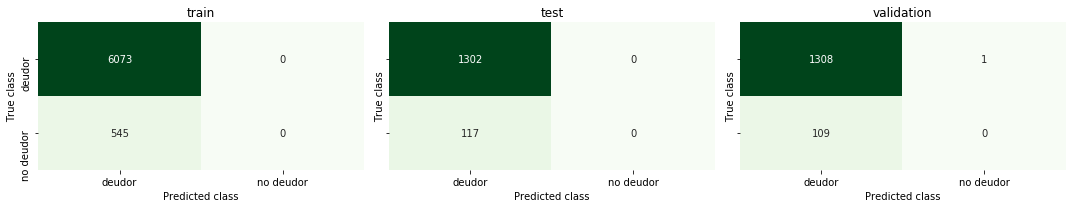

----------------------------------------------------------------------------------------------------------------------------
Mejor score (F1):  0.0
Mejores parámetros: 
 {'algorithm': 'auto', 'n_jobs': -1, 'n_neighbors': 8, 'p': 1, 'weights': 'uniform'}
----------------------------------------------------------------------------------------------------------------------------


In [99]:
i = 3
experiments = [(grid_search_knn_4, pipe_knn_4), 
               (grid_search_knn_5, pipe_knn_5)] 

get_model_results(i, experiments)

<u>Mejor modelo: ninguno de ellos</u>

* KNN no es un modelo aplicable a este problema, debido a que con las diferentes combinaciónes testeadas, no es capaz de realizar un training exitoso (overfitea o underfitea).

### Gradient Boosted Trees

In [15]:
def get_gradient_boosting_config(max_depths=[3], min_samples_splits=[2], min_samples_leafs=[1]):
    params = {
            'loss': ['deviance', 'exponential'],
            'n_estimators': [100, 120, 150],
            'criterion': ['friedman_mse', 'mse', 'mae'],
            'max_depth': max_depths,
            'min_samples_split': min_samples_splits,
            'min_samples_leaf': min_samples_leafs
        }
    
    model = GradientBoostingClassifier(random_state=1)
    
    return model, params

In [16]:
def make_GB_predictions(model, parameters):
    grid_search_gb = GridSearchCV(model, parameters, 
                                   scoring='f1', verbose=1)

    pipe_gb = Pipeline([
        ('mapper', mapper),
        ('imputer', IterativeImputer(random_state=1)),
        ('classifier', grid_search_gb),
    ])

    pipe_gb.fit(train, train.target)
    
    return pipe_gb, grid_search_gb

In [17]:
model_1, parameters_1 = get_gradient_boosting_config(max_depths=[5,6,7],
                                                     min_samples_splits=[80,100], 
                                                     min_samples_leafs=[10,15,20,30])

model_2, parameters_2 = get_gradient_boosting_config(max_depths=[9,10,11],
                                                     min_samples_splits=[80,100], 
                                                     min_samples_leafs=[10,15,20,30])

pipe_gb_1, grid_search_gb_1 = make_GB_predictions(model_1, parameters_1)
pipe_gb_2, grid_search_gb_2 = make_GB_predictions(model_2, parameters_2)

Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


KeyboardInterrupt: 

In [ ]:
i = 0
experiments = [(grid_search_gb_1, pipe_gb_1), 
               (grid_search_gb_2, pipe_gb_2)] 

get_model_results(i, experiments)

### Neural Network

In [36]:
def get_neural_network_config(layer_sizes=(100,), max_iters=[200]):
    params = {
            'hidden_layer_sizes': layer_sizes,
            'activation': ['identity', 'logistic', 'tanh', 'relu'],
            'solver': ['lbfgs', 'sgd', 'adam'],
            'max_iter': max_iters
        }
    
    model = MLPClassifier(random_state=1)
    
    return model, params

In [37]:
def make_NN_predictions(model, parameters):
    grid_search_nn = GridSearchCV(model, parameters, 
                                  scoring='f1', verbose=1)

    pipe_nn = Pipeline([
        ('mapper', mapper),
        ('imputer', IterativeImputer(random_state=1)),
        ('classifier', grid_search_nn),
    ])

    pipe_nn.fit(train, train.target)
    
    return pipe_nn, grid_search_nn

In [104]:
model_1, parameters_1 = get_neural_network_config(layer_sizes=[(80,),(90,),(100,)],
                                                  max_iters=[150,200,250])

model_2, parameters_2 = get_neural_network_config(layer_sizes=[(100,),(110,),(120,)],
                                                  max_iters=[150,200,250])

model_3, parameters_3 = get_neural_network_config(layer_sizes=[(100,),(200,),(300,)],
                                                  max_iters=[150,200,250])

pipe_nn_1, grid_search_nn_1 = make_NN_predictions(model_1, parameters_1)
pipe_nn_2, grid_search_nn_2 = make_NN_predictions(model_2, parameters_2)
pipe_nn_3, grid_search_nn_3 = make_NN_predictions(model_3, parameters_3)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\agus_\Miniconda3\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\agus_\Miniconda3\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\agus_\Miniconda3\envs\venv\lib\site-packages\sklearn\neural_netw

C:\Users\agus_\Miniconda3\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\agus_\Miniconda3\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\agus_\Miniconda3\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (

C:\Users\agus_\Miniconda3\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\agus_\Miniconda3\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\agus_\Miniconda3\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (

C:\Users\agus_\Miniconda3\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\agus_\Miniconda3\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\agus_\Miniconda3\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\agus_\Miniconda3\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LI

C:\Users\agus_\Miniconda3\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\agus_\Miniconda3\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\agus_\Miniconda3\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (

C:\Users\agus_\Miniconda3\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\agus_\Miniconda3\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\agus_\Miniconda3\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\agus_\Miniconda3\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization h

C:\Users\agus_\Miniconda3\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\agus_\Miniconda3\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\agus_\Miniconda3\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (

C:\Users\agus_\Miniconda3\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\agus_\Miniconda3\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\agus_\Miniconda3\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\agus_\Miniconda3\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization h

C:\Users\agus_\Miniconda3\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\agus_\Miniconda3\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\agus_\Miniconda3\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (

C:\Users\agus_\Miniconda3\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\agus_\Miniconda3\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\agus_\Miniconda3\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\agus_\Miniconda3\envs\venv\lib\site-pa

Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\agus_\Miniconda3\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\agus_\Miniconda3\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\agus_\Miniconda3\envs\venv\lib\site-packages\sklearn\neural_netw

C:\Users\agus_\Miniconda3\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\agus_\Miniconda3\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\agus_\Miniconda3\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (

C:\Users\agus_\Miniconda3\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\agus_\Miniconda3\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\agus_\Miniconda3\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\agus_\Miniconda3\envs\venv\lib\site-pa

C:\Users\agus_\Miniconda3\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\agus_\Miniconda3\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\agus_\Miniconda3\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.

C:\Users\agus_\Miniconda3\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\agus_\Miniconda3\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\agus_\Miniconda3\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maxi

C:\Users\agus_\Miniconda3\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\agus_\Miniconda3\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\agus_\Miniconda3\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.

C:\Users\agus_\Miniconda3\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\agus_\Miniconda3\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\agus_\Miniconda3\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\agus_\Miniconda3\envs\venv\lib\site-pa

C:\Users\agus_\Miniconda3\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\agus_\Miniconda3\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\agus_\Miniconda3\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.

C:\Users\agus_\Miniconda3\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\agus_\Miniconda3\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\agus_\Miniconda3\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maxi

C:\Users\agus_\Miniconda3\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\agus_\Miniconda3\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\agus_\Miniconda3\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
[Parallel(n_jobs=1)]: Done 540 out of 540 | elapsed: 27.1min finished
C:\Users\agus_\Miniconda3\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs f

Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\agus_\Miniconda3\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\agus_\Miniconda3\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\agus_\Miniconda3\envs\venv\lib\site-packages\sklearn\neural_netw

C:\Users\agus_\Miniconda3\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\agus_\Miniconda3\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\agus_\Miniconda3\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (

C:\Users\agus_\Miniconda3\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\agus_\Miniconda3\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\agus_\Miniconda3\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\agus_\Miniconda3\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization h

C:\Users\agus_\Miniconda3\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\agus_\Miniconda3\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\agus_\Miniconda3\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.

C:\Users\agus_\Miniconda3\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\agus_\Miniconda3\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\agus_\Miniconda3\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (

C:\Users\agus_\Miniconda3\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\agus_\Miniconda3\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\agus_\Miniconda3\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\agus_\Miniconda3\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization h

C:\Users\agus_\Miniconda3\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\agus_\Miniconda3\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\agus_\Miniconda3\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (

C:\Users\agus_\Miniconda3\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\agus_\Miniconda3\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\agus_\Miniconda3\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\agus_\Miniconda3\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization h

'Experiment 1'

,Accuracy,Precision,Recall,F1
train,0.952251,0.831884,0.526606,0.644944
test,0.872445,0.109756,0.076923,0.090452
validation,0.877997,0.136364,0.110092,0.121827


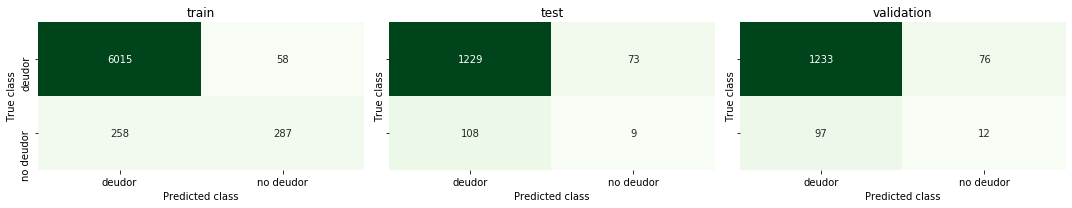

----------------------------------------------------------------------------------------------------------------------------
Mejor score (F1):  0.09013
Mejores parámetros: 
 {'activation': 'tanh', 'hidden_layer_sizes': (80,), 'max_iter': 250, 'solver': 'lbfgs'}
----------------------------------------------------------------------------------------------------------------------------


'Experiment 2'

,Accuracy,Precision,Recall,F1
train,0.937443,0.778723,0.335780,0.469231
test,0.880902,0.080645,0.042735,0.055866
validation,0.891396,0.105263,0.055046,0.072289


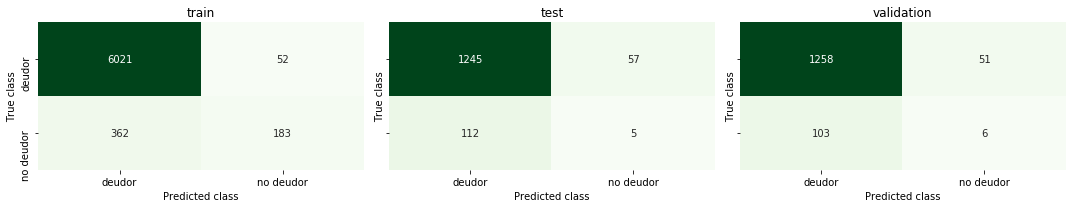

----------------------------------------------------------------------------------------------------------------------------
Mejor score (F1):  0.0909
Mejores parámetros: 
 {'activation': 'tanh', 'hidden_layer_sizes': (120,), 'max_iter': 200, 'solver': 'lbfgs'}
----------------------------------------------------------------------------------------------------------------------------


'Experiment 3'

,Accuracy,Precision,Recall,F1
train,0.941523,0.834746,0.361468,0.504481
test,0.887245,0.094340,0.042735,0.058824
validation,0.892807,0.109091,0.055046,0.073171


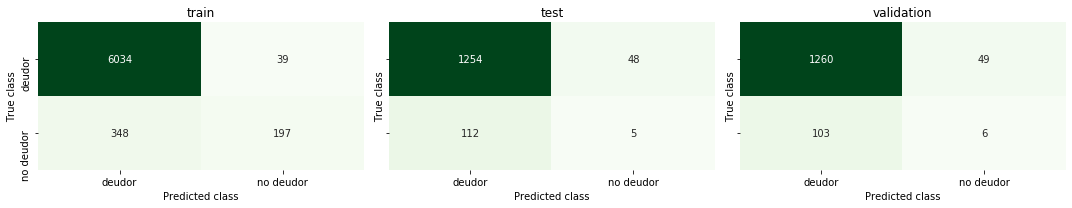

----------------------------------------------------------------------------------------------------------------------------
Mejor score (F1):  0.11704
Mejores parámetros: 
 {'activation': 'tanh', 'hidden_layer_sizes': (300,), 'max_iter': 250, 'solver': 'lbfgs'}
----------------------------------------------------------------------------------------------------------------------------


In [105]:
i = 0
experiments = [(grid_search_nn_1, pipe_nn_1), 
               (grid_search_nn_2, pipe_nn_2), 
               (grid_search_nn_3, pipe_nn_3)] 

get_model_results(i, experiments)

<u>Conclusiones generales</u>:

En función de las diferentes combinaciónes probadas para redes neuronales podemos determinar que a menor número de layers mejores fueron los resultados obtenidos (esto tiene sentido basándonos en el numero de samples que tenemos para el problema). En cuanto al número de iteraciónes necesario para converger a una solución la tendencia fue a escoger una cantidad superior a la por defecto.

En base a lo dicho, vamos a probar colocar un numero menor de layers para ver como se comporta el modelo.

In [42]:
model_4, parameters_4 = get_neural_network_config(layer_sizes=[(60,),(70,),(80,)],
                                                  max_iters=[250])

model_5, parameters_5 = get_neural_network_config(layer_sizes=[(40,),(50,),(60,)],
                                                  max_iters=[250])

pipe_nn_4, grid_search_nn_4 = make_NN_predictions(model_4, parameters_4)
pipe_nn_5, grid_search_nn_5 = make_NN_predictions(model_5, parameters_5)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\agus_\Miniconda3\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\agus_\Miniconda3\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\agus_\Miniconda3\envs\venv\lib\site-packages\sklearn\neural_netw

C:\Users\agus_\Miniconda3\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\agus_\Miniconda3\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\agus_\Miniconda3\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\agus_\Miniconda3\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization h

C:\Users\agus_\Miniconda3\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\agus_\Miniconda3\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\agus_\Miniconda3\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (

C:\Users\agus_\Miniconda3\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\agus_\Miniconda3\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\agus_\Miniconda3\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\agus_\Miniconda3\envs\venv\lib\site-pa

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\agus_\Miniconda3\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\agus_\Miniconda3\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\agus_\Miniconda3\envs\venv\lib\site-packages\sklearn\neural_netw

C:\Users\agus_\Miniconda3\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\agus_\Miniconda3\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\agus_\Miniconda3\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\agus_\Miniconda3\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization h

C:\Users\agus_\Miniconda3\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\agus_\Miniconda3\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\agus_\Miniconda3\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (

C:\Users\agus_\Miniconda3\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\agus_\Miniconda3\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\agus_\Miniconda3\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\agus_\Miniconda3\envs\venv\lib\site-pa

'Experiment 4'

,Accuracy,Precision,Recall,F1
train,0.948927,0.824451,0.482569,0.608796
test,0.865398,0.079545,0.059829,0.068293
validation,0.877997,0.152174,0.128440,0.139303


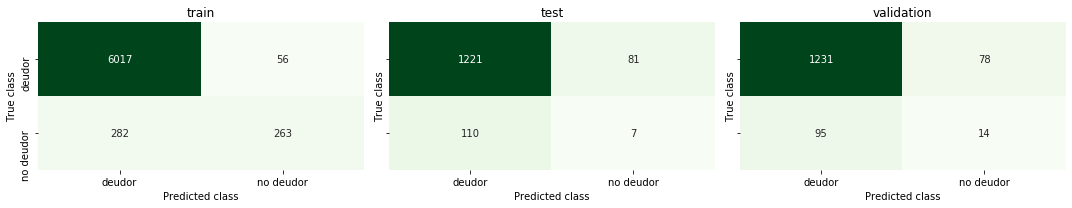

----------------------------------------------------------------------------------------------------------------------------
Mejor score (F1):  0.11557
Mejores parámetros: 
 {'activation': 'tanh', 'hidden_layer_sizes': (60,), 'max_iter': 250, 'solver': 'lbfgs'}
----------------------------------------------------------------------------------------------------------------------------


'Experiment 5'

,Accuracy,Precision,Recall,F1
train,0.948927,0.824451,0.482569,0.608796
test,0.865398,0.079545,0.059829,0.068293
validation,0.877997,0.152174,0.128440,0.139303


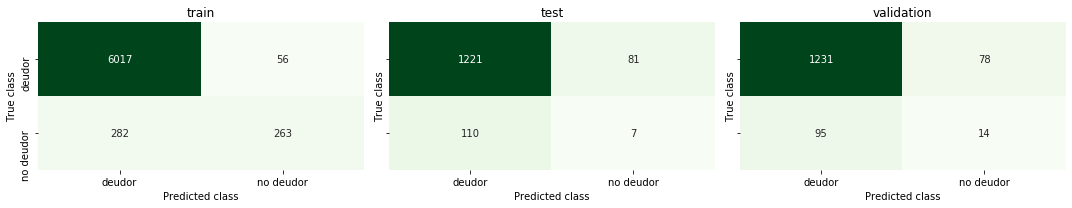

----------------------------------------------------------------------------------------------------------------------------
Mejor score (F1):  0.11557
Mejores parámetros: 
 {'activation': 'tanh', 'hidden_layer_sizes': (60,), 'max_iter': 250, 'solver': 'lbfgs'}
----------------------------------------------------------------------------------------------------------------------------


In [43]:
i = 3
experiments = [(grid_search_nn_4, pipe_nn_4), 
               (grid_search_nn_5, pipe_nn_5)] 

get_model_results(i, experiments)

En base a estos resultados podemos determinar que el mejor numero de layers para la red neuronal es de 60, ya que mejora su f-1 score con relación a 80 layers (experimento 1, el mas performante), y no continúa disminuyendo este hiperparámetro en el experimento 5.

<u>Conclusiones</u>:
* El precission alcanzado por el experimento 4 (el "mejor") es de %0.07
* No obstante, recall es de apenas un ≈5%.
* Este recall tan bajo nos lleva a tener un F1 de apenas 0.07 aprox.

# Conclusiones finales

Ninguno de los modelos testeados logra una performance destacable (no se supera el 12% en precission ni el 20% en F1-score). En función de esto, la elección de el "mejor modelo" resulta un tanto superflua debido a la poca variabilidad en los resultados. A su vez, debemos tener en cuenta que es lo que mas le interesa al cliente a la hora de la elección del modelo, resultando conveniente la organización de reuniones incrementales para análisis de resultados.

Mas allá de esto, consideramos que el "mejor modelo" de los evaluados es xxxx.

# Trabajo Futuro

* Nuestro objetivo central debería ser conseguir mas información. En esto recae el progreso que podamos ver en los modelos, en otras palabras, es mucho mas el terreno que podemos ganar realizando análisis y feature engineering con nuevas versiones del dataset que tuneando hiperparámetros.

* Volver a correr los presentes experimentos utilizando otras técnicas para encoding de variables categóricas tales como "leave one out" o "target encoder".

* Definir con el cliente el tresh old entre precission y recall, ¿Que le interesa mas? ¿Cual es el umbrál para clasificar el resultado de un modelo como útil?

* Probar otros modelos.